In [1]:
import sqlite3 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp_stats

In [2]:
DB_FN_FULL = "../db/massbank__only_normalized_scores.sqlite"
DB_URI_FULL = "file:" + DB_FN_FULL + "?mode=ro"
DB_CONN_FULL_RO = sqlite3.connect(DB_URI_FULL, uri=True)

METLIN_DATA = pd.read_csv("metlin_data.tsv", sep="\t")

In [3]:
for idx, (ds, ) in enumerate(DB_CONN_FULL_RO.execute(
    "SELECT distinct(dataset) FROM scored_spectra_meta "
    "   INNER JOIN datasets d on scored_spectra_meta.dataset = d.name"
    "   WHERE column_type IS 'RP'"
)):
    # Fetch accessions associated with the current dataset
    acc, inchikeys, inchikeys1 = zip(*DB_CONN_FULL_RO.execute(
        "SELECT accession, inchikey, inchikey1 FROM scored_spectra_meta"
        "   INNER JOIN datasets d ON scored_spectra_meta.dataset = d.name"
        "   INNER JOIN molecules m ON scored_spectra_meta.molecule = m.cid"
        "   WHERE retention_time >= 3 * column_dead_time_min"  # Filter non-interacting molecules      
        "     AND dataset IS ?", (ds, )
    ).fetchall())
    
    n_acc = len(acc)
    
    if n_acc <= 75:
        print(idx, ds, 1, n_acc)
    elif n_acc <= 250:
        print(idx, ds, 15, n_acc)
    else:
        print(idx, ds, n_acc // 50, n_acc)

0 AC_003 15 179
1 AU_003 15 90
2 AU_002 14 746
3 BML_001 15 250
4 CE_001 1 39
5 EA_003 6 307
6 EA_002 6 301
7 EQ_006 15 211
8 EQ_004 15 181
9 ET_002 1 50
10 KW_000 1 55
11 LU_001 11 567
12 NA_003 15 97
13 PR_002 18 911
14 RP_001 15 150
15 SM_001 7 357
16 UF_003 15 140
17 UF_002 15 149
18 AU_000 15 168
19 BML_000 15 170
20 BS_000 15 216
21 EA_000 15 141
22 EA_001 15 147
23 EQ_003 15 92
24 EQ_001 15 86
25 LQB_000 6 301
26 LU_000 7 358
27 PR_000 14 709
28 RP_000 1 69
29 SM_000 15 161
30 UT_000 6 318


## Overlap of MassBank with the METLIN Retention Time Dataset

In [13]:
df_overlap = []

for idx, (ds, ) in enumerate(DB_CONN_FULL_RO.execute(
    "SELECT distinct(dataset) FROM scored_spectra_meta "
    "   INNER JOIN datasets d on scored_spectra_meta.dataset = d.name"
    "   WHERE column_type IS 'RP'"
)):
    # Fetch accessions associated with the current dataset
    df_ds = pd.read_sql(
        "SELECT accession, cid, inchikey, inchikey1, retention_time as rt FROM scored_spectra_meta"
        "   INNER JOIN datasets d ON scored_spectra_meta.dataset = d.name"
        "   INNER JOIN molecules m ON scored_spectra_meta.molecule = m.cid"
        "   WHERE retention_time >= 3 * column_dead_time_min"  # Filter non-interacting molecules      
        "     AND dataset IS '%s'" % ds, 
        DB_CONN_FULL_RO
    )
    
    #df_ds = pd.read_sql(
    #    "SELECT accession, cid, inchikey, inchikey1, retention_time as rt FROM spectra_meta"
    #    "   INNER JOIN datasets d ON spectra_meta.dataset = d.name"
    #    "   INNER JOIN molecules m ON spectra_meta.molecule = m.cid"
    #    "   INNER JOIN spectra_rts sr ON spectra_meta.accession = sr.spectrum"
    #    "   WHERE retention_time >= 3 * column_dead_time_min"  # Filter non-interacting molecules      
    #    "     AND dataset IS '%s'" % ds, 
    #    DB_CONN_FULL_RO
    #)
    
    print(ds, len(df_ds))
    
    for key in ["inchikey", "inchikey1"]:
        df_merge = pd.merge(METLIN_DATA, df_ds, on=key)

        df_overlap.append([
            ds,
            len(df_merge), 
            df_merge["rt_x"].tolist(), 
            df_merge["rt_y"].tolist(),
            key
        ])
    

df_overlap = pd.DataFrame(df_overlap, columns=["dataset", "n_overlap_with_metlin", "metlin_rt", "massbank_rt", "merged_on"])

AC_003 179
AU_003 90
AU_002 746
BML_001 250
CE_001 39
EA_003 307
EA_002 301
EQ_006 211
EQ_004 181
ET_002 50
KW_000 55
LU_001 567
NA_003 97
PR_002 911
RP_001 150
SM_001 357
UF_003 140
UF_002 149
AU_000 168
BML_000 170
BS_000 216
EA_000 141
EA_001 147
EQ_003 92
EQ_001 86
LQB_000 301
LU_000 358
PR_000 709
RP_000 69
SM_000 161
UT_000 318


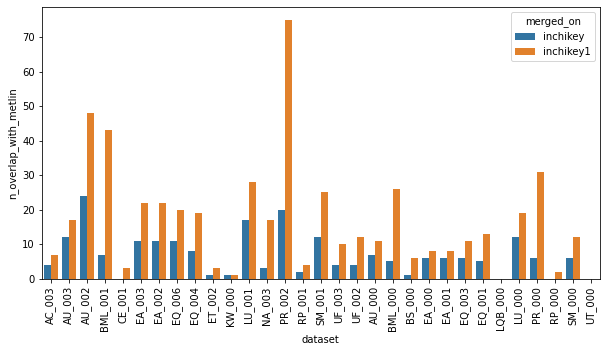

In [14]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_overlap, x="dataset", y="n_overlap_with_metlin", hue="merged_on")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

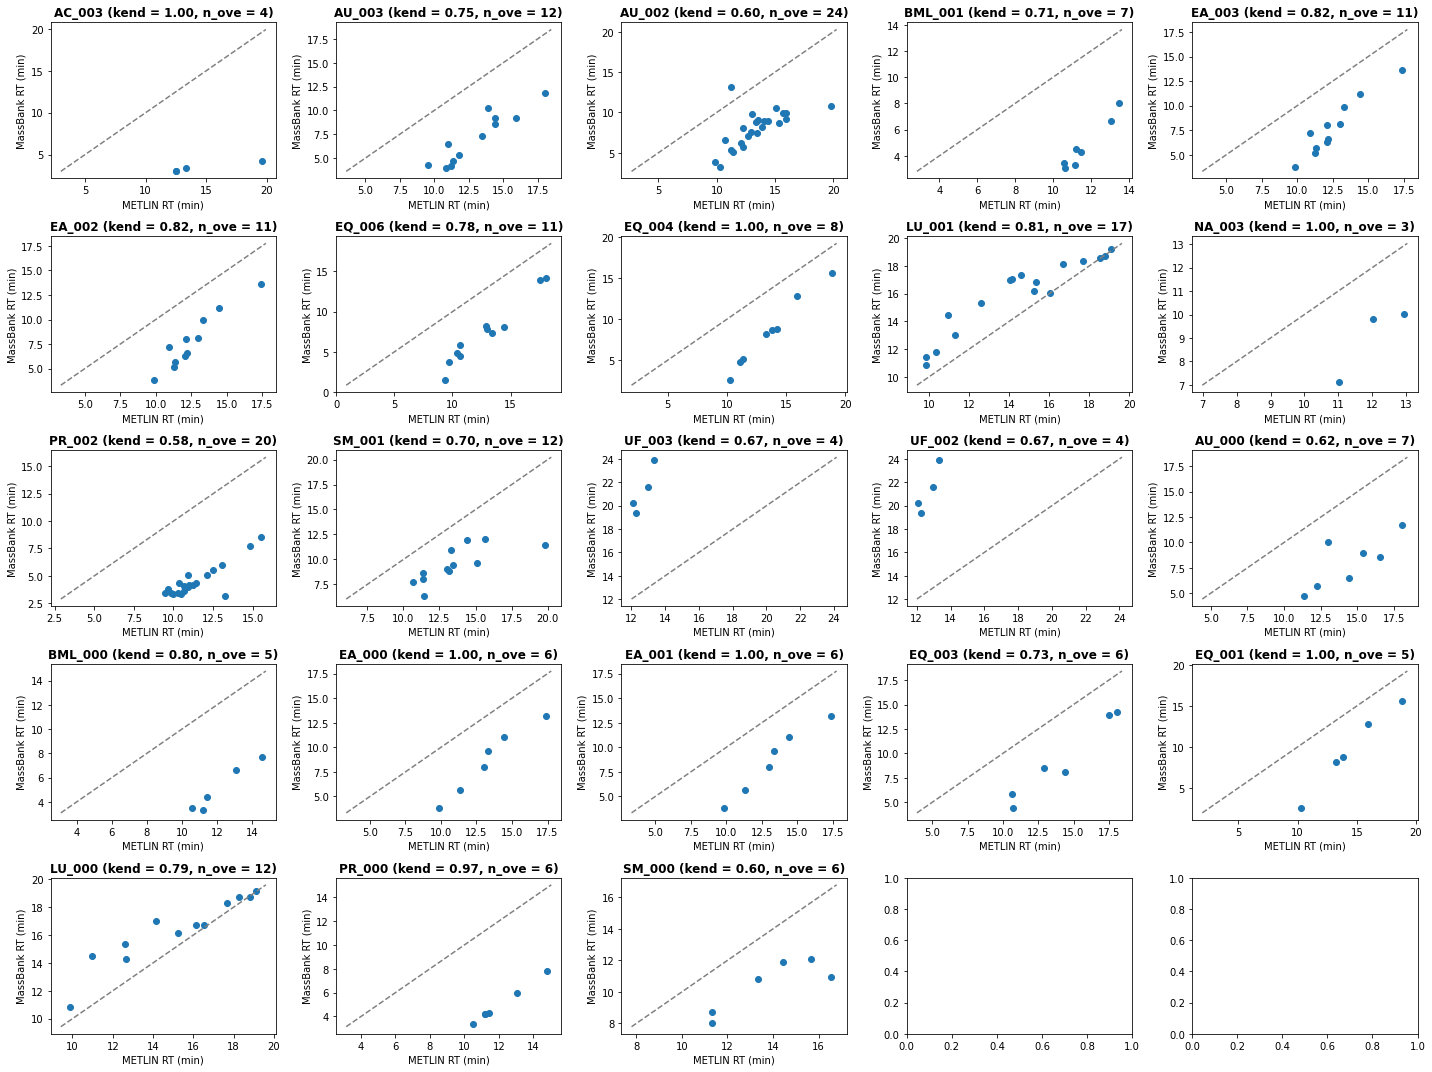

In [19]:
fig, axrr = plt.subplots(5, 5, figsize=(20, 15))

idx = 0
for i, row in df_overlap[df_overlap["merged_on"] == "inchikey"].iterrows():
    
    if row["n_overlap_with_metlin"] < 3: 
        continue
    
    r, c = np.unravel_index(idx, axrr.shape)
    axrr[r, c].scatter(row["metlin_rt"], row["massbank_rt"])
    axrr[r, c].set_title("%s (kend = %.2f, n_ove = %d)" % (row["dataset"], sp_stats.kendalltau(row["metlin_rt"], row["massbank_rt"])[0], row["n_overlap_with_metlin"]), fontweight="bold")
    axrr[r, c].set_xlabel("METLIN RT (min)")
    axrr[r, c].set_ylabel("MassBank RT (min)")
    _x_min, _x_max = axrr[r, c].get_xlim()
    _y_min, _y_max = axrr[r, c].get_ylim()
    axrr[r, c].plot(
        [np.minimum(_x_min, _y_min), np.maximum(_x_max, _y_max)], 
        [np.minimum(_x_min, _y_min), np.maximum(_x_max, _y_max)],
        linestyle="--", color="gray"
    )
    
    idx += 1
    
plt.tight_layout()